# IITP 1차반 12주차 project

나와 함께 하자구~

* https://github.com/namwoo
* https://www.kaggle.com/c/2019-3rd-ml-month-with-kakr


![](https://github.com/NamWoo/self_driving_car/raw/master/img/intro.jpg)

![KakaoTalk_20190802_145850306](https://user-images.githubusercontent.com/8021479/62352336-e40c6f80-b542-11e9-96d1-15570400793e.jpg)


## setting

In [116]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [117]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/device:GPU:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Ensure that TF can detect the GPU.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.1164223740015586
GPU (s):
0.098079998002504
GPU speedup over CPU: 31x


Nvidia T4s

In [118]:
# OS
!cat /etc/issue.net

Ubuntu 18.04.2 LTS


In [119]:
# CPU 사양
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0


In [120]:
# 메모리 사양
!head -n 3 /proc/meminfo

MemTotal:       13335268 kB
MemFree:         4601408 kB
MemAvailable:   10259068 kB


In [121]:
# 디스크 사양
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   31G  310G   9% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/sda1       365G   40G  326G  11% /opt/bin
tmpfs           6.4G   12K  6.4G   1% /var/colab
shm             6.0G  8.0K  6.0G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            17G   17G  366M  98% /content/gdrive


In [7]:
!python --version

Python 3.6.8


In [122]:
!nvidia-smi

Fri Aug  2 04:53:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   8947MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# proj 시작

## 구글 드라이브 연동

In [125]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'
path = root_path + '!DataSets/2019-3rd-ml-month-with-kakr/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 임포트

In [126]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

'channels_last'

In [0]:
import PIL
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

BATCH_SIZE = 32
EPOCHS = 100
k_folds = 3
TTA_STEPS = 5
PATIENCE = 6
SEED = 2019
BASE_MODEL = Xception
IMAGE_SIZE = 299

In [128]:
os.listdir(path)

['train',
 'test',
 'class.csv',
 'sample_submission.csv',
 'train.csv',
 'test.csv',
 'cropped_train',
 'cropped_test',
 'aa']

파일 정보
* train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* submission.csv - Test셋과 대응되는 제출 파일
* class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
* train - Train 이미지 파일
* test - Test 이미지 파일

시트 정보
* img_file - 데이터 셋의 각 로우와 연결되는 이미지 파일 이름
* bbox_x1 - 바운딩 박스 x1 좌표 (좌상단 x)
* bbox_y1 - 바운딩 박스 y1 좌표 (좌상단 y)
* bbox_x2 - 바운딩 박스 x2 좌표 (우하단 x)
* bbox_y2 - 바운딩 박스 y2 좌표 (우하단 y)
* class - 예측하려는 차종(Target)
* id - 각 데이터 셋에 기입 되어 있는 클래스 id
* name - 클래스 id에 대응되는 실제 차종 레이블

## 데이터 파악

In [0]:
TRAIN_IMG_PATH = os.path.join(path, 'train')
TEST_IMG_PATH = os.path.join(path, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(path, 'train.csv'))
df_test = pd.read_csv(os.path.join(path, 'test.csv'))
df_class = pd.read_csv(os.path.join(path, 'class.csv'))

In [132]:
print(df_train.shape)
df_train.head()

(9990, 6)


,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [133]:
print(df_test.shape)
df_test.head()

(6150, 5)


,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [135]:
# 폴더에 있는 실제 이미지 파일과 csv에 있는 이미지가 맞게 잘 있는지 확인
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


In [136]:
# Data 갯수
print("Number of Train Data : {}".format(df_train.shape[0]))
print("Number of Test Data : {}".format(df_test.shape[0]))

Number of Train Data : 9990
Number of Test Data : 6150


In [134]:
print(df_class.shape)
df_class.head(10)

(196, 2)


,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012
5,6,Acura Integra Type R 2001
6,7,Acura ZDX Hatchback 2012
7,8,Aston Martin V8 Vantage Convertible 2012
8,9,Aston Martin V8 Vantage Coupe 2012
9,10,Aston Martin Virage Convertible 2012


In [139]:
print("타겟 클래스 총 갯수 : {}".format(df_class.shape[0]))    #class csv의 col 갯수
print("Train Data의 타겟 종류 갯수 : {}".format(df_train['class'].nunique()))

타겟 클래스 총 갯수 : 196
Train Data의 타겟 종류 갯수 : 196


Class Distribution

분류 문제 Target Class의 분포 

Train Set의 타겟 분포를 확인해서 밸런스가 어느정도인지 체크

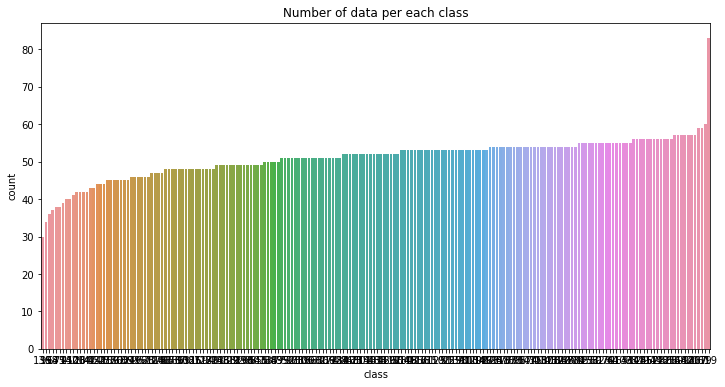

In [140]:
plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

In [141]:
df_class[:1]

,id,name
0,1,AM General Hummer SUV 2000


In [142]:
df_class[-2:-1]

,id,name
194,195,Volvo XC90 SUV 2007


In [143]:
cntEachClass = df_train["class"].value_counts(ascending=False)
print("Class with most count  : {}".format(cntEachClass.index[0]))
print("Most Count : {}".format(cntEachClass.max()))

print("Class with fewest count  : {}".format(cntEachClass.index[-1]))
print("Fewest Count : {}".format(cntEachClass.min()))

print("Mean  : {}".format(cntEachClass.mean()))

Class with most count  : 119
Most Count : 83
Class with fewest count  : 136
Fewest Count : 30
Mean  : 50.96938775510204


In [144]:
cntEachClass.describe()

count    196.000000
mean      50.969388
std        5.374115
min       30.000000
25%       48.000000
50%       52.000000
75%       54.000000
max       83.000000
Name: class, dtype: float64

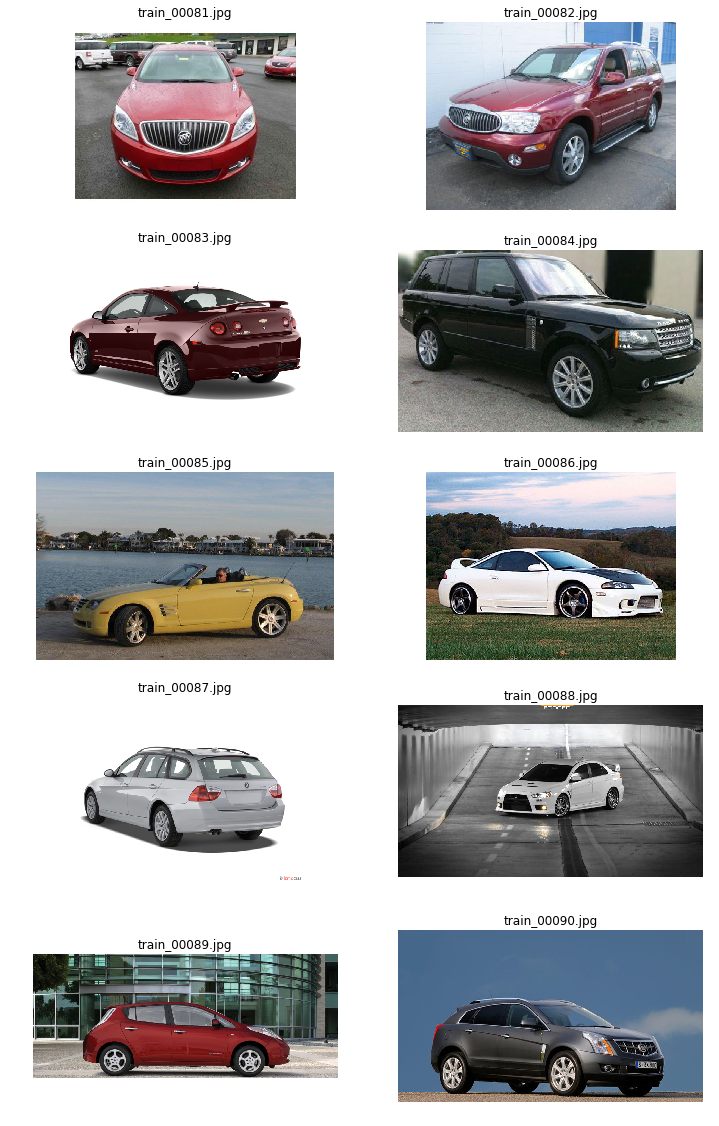

In [145]:
import PIL
from PIL import ImageDraw

tmp_imgs = df_train['img_file'][80:90]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

## 이미지 전처리

### Bounding Box

In [0]:
def draw_rect(drawcontext, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

def make_boxing_img(img_name) :
    if img_name.split('_')[0] == "train" :
        PATH = TRAIN_IMG_PATH
        data = df_train
    elif img_name.split('_')[0] == "test" :
        PATH = TEST_IMG_PATH
        data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='yellow', width=10)
    
    return img

In [147]:
f_name = "train_00991.jpg"
os.path.join(TRAIN_IMG_PATH, f_name)

'gdrive/My Drive/!DataSets/2019-3rd-ml-month-with-kakr/train/train_00991.jpg'

In [148]:
f_class = df_train.loc[df_train.img_file == f_name,]
f_class

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
990,train_00991.jpg,247,216,749,477,103


In [149]:
f_class.values[0][5]

103

In [150]:
df_class.loc[df_class.id == f_class.values[0][5],]

,id,name
102,103,Ferrari 458 Italia Convertible 2012


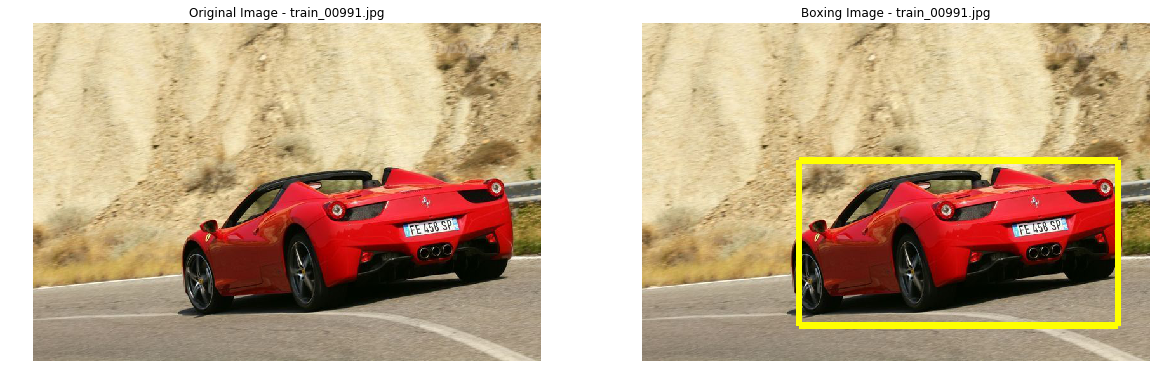

In [151]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
# Original Image
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))   #os.path.join(TRAIN_IMG_PATH, f_name)
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

# Image included bounding box
plt.subplot(1, 2, 2)
boxing = make_boxing_img(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

In [0]:
def crop_boxing_img(img_name, margin=0, size=(IMAGE_SIZE,IMAGE_SIZE)):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        PATH = TEST_IMG_PATH
        data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1, y1, x2, y2)).resize(size)

In [0]:
# %%time
# TRAIN_CROPPED_PATH = path + '/cropped_train'
# TEST_CROPPED_PATH = path + '/cropped_test'

# if (os.path.isdir(TRAIN_CROPPED_PATH) == False):
#     os.mkdir(TRAIN_CROPPED_PATH)

# if (os.path.isdir(TEST_CROPPED_PATH) == False):
#     os.mkdir(TEST_CROPPED_PATH)

# for i, row in df_train.iterrows():
#     cropped = crop_boxing_img(row['img_file'])
#     cropped.save(os.path.join(TRAIN_CROPPED_PATH, row['img_file']))

# for i, row in df_test.iterrows():
#     cropped = crop_boxing_img(row['img_file'])
#     cropped.save(os.path.join(TEST_CROPPED_PATH, row['img_file']))

## 크롭이미지 기본이미지 교체

In [0]:
# root_path = 'gdrive/My Drive/'
# path = root_path + '!DataSets/2019-3rd-ml-month-with-kakr/'

TRAIN_IMG_PATH = os.path.join(path, 'cropped_train')
TEST_IMG_PATH = os.path.join(path, 'aa')   #cropped_train


df_train['class'] = df_train['class'].astype('str')
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

In [159]:
# 폴더에 있는 실제 이미지 파일과 csv에 있는 이미지가 맞게 잘 있는지 확인
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


In [0]:
a = list(df_test.img_file)
b = os.listdir(TEST_IMG_PATH)

## 학습 준비

---

Train_test_split


In [161]:
from sklearn.model_selection import train_test_split

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(7992, 2)
(1998, 2)
(6150, 1)


### Generator
* https://www.opentutorials.org/module/3873/23171
* https://keras.io/preprocessing/image/

In [163]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Parameter
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    zoom_range=0.10,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train, 
    directory = TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = TEST_IMG_PATH,
    x_col = 'img_file',
    y_col = None,
    target_size = img_size,
    color_mode= 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False
)

Found 7992 validated image filenames belonging to 196 classes.
Found 1998 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.


### Resnet50

![](https://cdn-images-1.medium.com/max/987/1*pUyst_ciesOz_LUg0HocYg.png)
* http://www.arxiv.org/abs/1512.03385
* https://keras.io/preprocessing/image/

In [0]:
resNet_model = ResNet50(include_top = False, input_shape = (224,224,3))
# resNet_model.summary()

In [165]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# for layer in resNet_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

model = Sequential()
model.add(resNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

### 학습시작

In [0]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [169]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_resnet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

# ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [es]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

Epoch 1/20
250/250 [==============================] - 160s 639ms/step - loss: 4.8611 - acc: 0.0437 - val_loss: 12.6024 - val_acc: 0.0125
Epoch 2/20
250/250 [==============================] - 146s 583ms/step - loss: 3.1739 - acc: 0.2228 - val_loss: 4.0937 - val_acc: 0.1677
Epoch 3/20
250/250 [==============================] - 145s 578ms/step - loss: 1.8331 - acc: 0.5019 - val_loss: 2.7411 - val_acc: 0.3353
Epoch 4/20
250/250 [==============================] - 142s 567ms/step - loss: 1.1254 - acc: 0.6806 - val_loss: 1.9673 - val_acc: 0.5165
Epoch 5/20
250/250 [==============================] - 141s 564ms/step - loss: 0.7659 - acc: 0.7725 - val_loss: 1.8181 - val_acc: 0.5355
Epoch 6/20
250/250 [==============================] - 140s 560ms/step - loss: 0.5250 - acc: 0.8410 - val_loss: 1.2916 - val_acc: 0.6772
Epoch 7/20
250/250 [==============================] - 140s 560ms/step - loss: 0.4061 - acc: 0.8769 - val_loss: 1.6503 - val_acc: 0.6091
Epoch 8/20
250/250 [===========================

### 모델평가

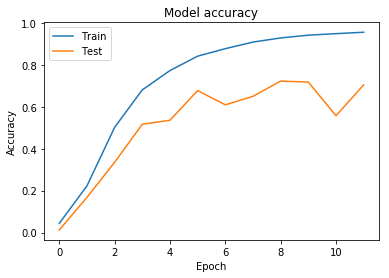

In [170]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

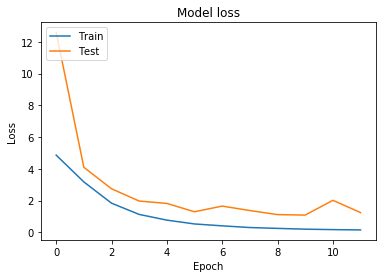

In [171]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 테스트 셋 적용

In [172]:
%%time
test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

193/193 [==============================] - 1962s 10s/step
CPU times: user 43.6 s, sys: 15.6 s, total: 59.2 s
Wall time: 32min 42s


In [0]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [174]:
len(predicted_class_indices)

6150

## 제출 설정

In [0]:
submission = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [176]:
submission.tail()

,img_file,class
6145,test_06146.jpg,0
6146,test_06147.jpg,0
6147,test_06148.jpg,0
6148,test_06149.jpg,0
6149,test_06150.jpg,0


In [177]:
len(predictions)

6150

### 제출

In [179]:
submission["class"] = predictions
submission.to_csv(path +"submission.csv", index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,58
4,test_00005.jpg,18


## 제출결과

2019년 8년 2월  12주차 프로젝트 base line 만들기

![qq](https://user-images.githubusercontent.com/8021479/62352105-50d33a00-b542-11e9-885c-39d17b8ccaed.png)